<h1>The Roots package</h1>

<p>The <code>Roots</code> package contains simple routines for finding zeros of continuous scalar functions of a single real variable.  A zero of $f$ is a value $c$ where $f(c) = 0$.  The basic interface is through the function <code>find_zero</code>, which through multiple dispatch can handle many different cases.</p>

<p>We will use <code>Plots</code> for plotting.</p>

In [1]:
using Roots  
using Plots
pyplot()

Plots.PyPlotBackend()

<h2>Bracketing</h2>

<p>For a function $f: R \rightarrow R$ a <em>bracket</em> is a pair $ a < b $ for which $f(a) \cdot f(b) < 0$. That is they have different signs. If $f$ is a continuous function this ensures there to be a zero (a $c$ with $f(c) = 0$) in the interval $[a,b]$, otherwise, if $f$ is only piecewise continuous, there must be a point $c$ in $[a,b]$ with the left limit and right limit at $c$ having different signs (or $0$). Such values can be found, up to floating point roundoff.</p>

<p>That is, given <code>f&#40;a&#41; * f&#40;b&#41; &lt; 0</code>, a value <code>c</code> with <code>a &lt; c &lt; b</code> can be found where either <code>f&#40;c&#41; &#61;&#61; 0.0</code> or at least <code>f&#40;prevfloat&#40;c&#41;&#41; * f&#40;nextfloat&#40;c&#41;&#41; &lt;&#61; 0</code>.</p>

<p>To illustrate, consider the function $f(x) = \cos(x) - x$. From the graph we see readily that $[0,1]$ is a bracket (which we emphasize with an overlay):</p>

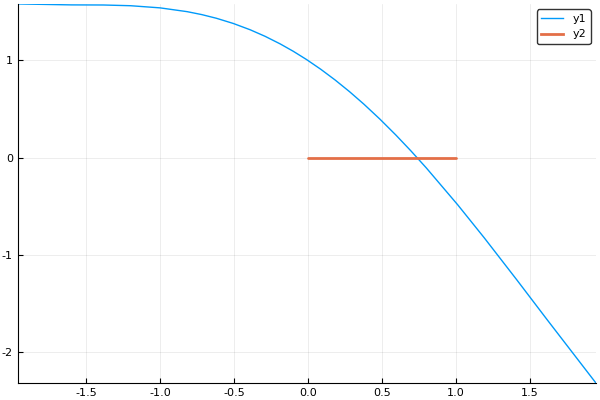

In [1]:
f(x) = cos(x) - x
plot(f, -2, 2)
plot!([0,1], [0,0], linewidth=2)

<p>We use a vector or tuple to specify the initial condition for <code>Bisection</code>:</p>

In [1]:
x = find_zero(f, (0, 1), Bisection())    # alternatively fzero(f, [0, 1])
x, f(x)

(0.7390851332151607, 0.0)

<p>For this function we see that <code>f&#40;x&#41; &#61;&#61; 0.0</code>.</p>

<hr />

<p>Next consider $f(x) = \sin(x)$. A known root is $\pi$. Trignometry tells us that $[\pi/2, 3\pi/2]$ will be a bracket. Here <code>Bisection&#40;&#41;</code> is not specified, as it will be the default when the initial value is specified as pair of numbers:</p>

In [1]:
f(x) = sin(x)
x = find_zero(f, (pi/2, 3pi/2))
x, f(x)

(3.141592653589793, 1.2246467991473532e-16)

<p>This value of <code>x</code> does not produce <code>f&#40;x&#41; &#61;&#61; 0.0</code>, however, it is as close as can be:</p>

In [1]:
f(prevfloat(x)) * f(x) < 0.0 || f(x) * f(nextfloat(x)) < 0.0

true

<p>That is, at <code>x</code> the function is changing sign.</p>

<p>From a mathematical perspective, a zero is guaranteed for a <em>continuous</em> function. However, the computer algorithm doesn't assume continuity, it just looks for changes of sign. As such, the algorithm will  identify discontinuities, not just zeros. For example:</p>

In [1]:
find_zero(x -> 1/x, (-1, 1))

-0.0

<p>The endpoints can even be infinite:</p>

In [1]:
find_zero(x -> Inf*sign(x), (-Inf, Inf))  # Float64 only

0.0

<p>The basic algorithm used for bracketing when the values are simple floating point values is the bisection method. For big float values, an algorithm due to Alefeld, Potra, and Shi is used.</p>

In [1]:
find_zero(sin, (big(3), big(4)))    # uses a different algorithm then for (3,4)

3.141592653589793238462643383279502884197169399375105820974944592307816406286198

<h2>Using an initial guess</h2>

<p>Bracketing methods have guaranteed convergence, but in general require many more function calls than are needed to produce an answer.  If a good initial guess is known, then the <code>find_zero</code> function provides an interface to some different iterative algorithms that are more efficient. Unlike bracketing methods, these algorithms may not converge to the desired root if the initial guess is not well chosen.</p>

<p>The default algorithm is modeled after an algorithm used for <a href="http://www.hpl.hp.com/hpjournal/pdfs/IssuePDFs/1979-12.pdf">HP-34 calculators</a>. This algorithm is designed to be more forgiving of the quality of the initial guess at the cost of possibly performing many more steps. In many cases it satisfies the criteria for a bracketing solution, as it will use bracketing if within the algorithm a bracket is identified.</p>

<p>For example, the answer to our initial problem is near 1. Given this, we can find the zero with:</p>

In [1]:
f(x) = cos(x) - x
x = find_zero(f , 1)
x, f(x)

(0.7390851332151607, 0.0)

<p>For the polynomial $f(x) = x^3 - 2x - 5$, an initial guess of 2 seems reasonable:</p>

In [1]:
f(x) = x^3 - 2x - 5
x = find_zero(f, 2)
x, f(x), sign(f(prevfloat(x)) * f(nextfloat(x)))

(2.0945514815423265, -8.881784197001252e-16, -1.0)

<p>For even more precision, <code>BigFloat</code> numbers can be used</p>

In [1]:
x = find_zero(sin, big(3))
x, sin(x), x - pi

(3.141592653589793238462643383279502884197169399375105820974944592307816406286198, 1.096917440979352076742130626395698021050758236508687951179005716992142688513354e-77, 0.000000000000000000000000000000000000000000000000000000000000000000000000000000)

<h3>Higher order methods</h3>

<p>The default call to <code>fzero</code> uses a first order method and then possibly bracketing, which involves potentially many more function calls. Though specifying a initial value is more convenient than a bracket, there may be times where a more efficient algorithm is sought. For such, a higher-order method might be better suited. There are algorithms <code>Order1</code> (secant method), <code>Order2</code> (<a href="http://en.wikipedia.org/wiki/Steffensen&#39;s_method">Steffensen</a>), <code>Order5</code>, <code>Order8</code>, and <code>Order16</code>. The order 2 method is generally more efficient, but is more sensitive to the initial guess than, say, the order 8 method. These algorithms are accessed by specifying the method after the initial point:</p>

In [1]:
f(x) = 2x - exp(-x)
x = find_zero(f, 1, Order2())      # also fzero(f, 1, order=2)
x, f(x)

(0.3517337112491958, -1.1102230246251565e-16)

In [1]:
f(x) = (x + 3) * (x - 1)^2
x = find_zero(f, -2, Order5())
x, f(x)

(-3.0, 0.0)

In [1]:
x = find_zero(f, 2, Order8())
x, f(x)

(1.0000000027152591, 2.949052856287529e-17)

<p>The latter shows that zeros need not be simple zeros (i.e. $f'(x) = 0$, if defined) to be found. (Though non-simple zeros may take many more steps to converge.)</p>

<p>To investigate the algorithm and its convergence, the argument <code>verbose&#61;true</code> may be specified.</p>

<p>For some functions, adjusting the default tolerances may be necessary to achieve convergence. These include <code>atol</code> and <code>rtol</code>, which are used to check if $f(x_n) \approx 0$; <code>xatol</code>, <code>xrtol</code>, to check if $x_n \approx x_{n-1}$; and <code>maxevals</code> and <code>maxfnevals</code> to limit the number of steps in the algorithm or function calls.</p>

<p>The higher-order methods are basically various derivative-free versions of Newton's method (which has update step $x - f(x)/f'(x)$). For example, Steffensen's method is essentially replacing $f'(x)$ with $(f(x + f(x)) - f(x))/f(x)$. This is a forward-difference approximation to the derivative with "$h$" being $f(x)$, which presumably is close to $0$ already. The methods with higher order combine this with different secant line approaches that minimize the number of function calls. These higher-order methods can be susceptible to some of the usual issues found with Newton's method: poor initial guess, small first derivative, or large second derivative near the zero.</p>

<hr />

<p>For a classic example where a large second derivative is the issue, we have $f(x) = x^{1/3}$:</p>

In [1]:
f(x) = cbrt(x)
x = find_zero(f, 1, Order2())	# all of 2, 5, 8, and 16 fail or diverge towards infinity

Roots.ConvergenceFailed("Stopped at: xn = -2.1990233589964556e12")


<p>However, the default finds the root here, as a bracket is identified:</p>

In [1]:
x = find_zero(f, 1)
x,  f(x)

(0.0, 0.0)

<p>Order 8 illustrates that sometimes the stopping rules can be misleading and checking the returned value is always a good idea:</p>

In [1]:
find_zero(f, 1, Order8())

5.036302449511863e15

<p>The algorithm rapidly marches off towards infinity so the relative tolerance $\approx |x| \cdot \epsilon$ is large compared to the far-from zero $f(x)$.</p>

<hr />

<p>This example illustrates that the default <code>find_zero</code> call is more forgiving to an initial guess. The devilish function defined below comes from a <a href="http://people.sc.fsu.edu/~jburkardt/cpp_src/test_zero/test_zero.html">test suite</a> of difficult functions. The default method finds the zero starting at 0:</p>

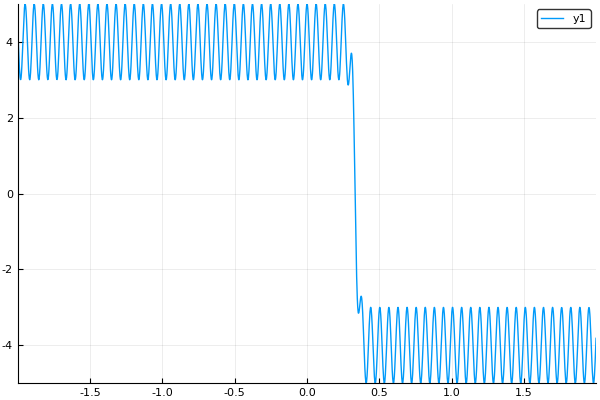

In [1]:
f(x) = cos(100*x)-4*erf(30*x-10)
plot(f, -2, 2)

In [1]:
find_zero(f, 0)

0.3318660335745625

<p>Whereas, with higher order methods fail. For example,</p>

In [1]:
find_zero(f, 0, Order8())

Roots.ConvergenceFailed("Stopped at: xn = 34772.380550438844")


<p>Basically the high order oscillation can send the proxy tangent line off in nearly random directions. The default method can be fooled here too.</p>

<hr />

<p>Finally, for many functions, all of these methods need a good initial guess. For example, the polynomial function $f(x) = x^5 - x - 1$ has its one zero near $1.16$. If we start far from it, convergence may happen, but it isn't guaranteed:</p>

In [1]:
f(x) = x^5 - x - 1
x0 = 0.1
find_zero(f, x0)

1.1673039782614185

<p>Whereas, </p>

In [1]:
find_zero(f, x0, Order2())

Roots.ConvergenceFailed("Stopped at: xn = -0.7503218333241642")


<p>A graph shows the issue. We have overlayed 15 steps of Newton's method, the other algorithms being somewhat similar:</p>

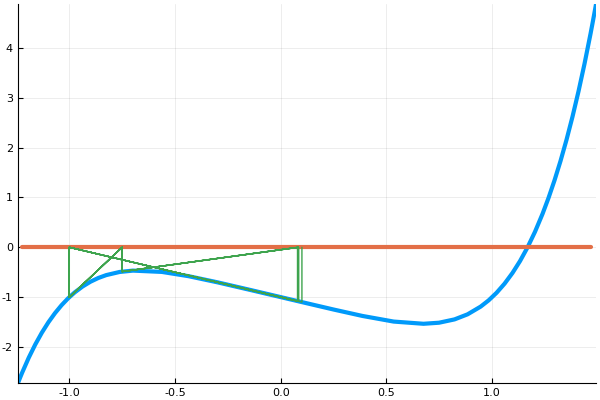

<p>Though 15 steps are shown, only a few are discernible, as the function's relative maximum causes a trap for this algorithm. Starting to the right of the relative minimum – nearer the zero – would avoid this trap. The default method employs a trick to bounce out of such traps, though it doesn't always work.</p>

<h2>Finding more than one zero</h2>

<p>The bracketing methods suggest a simple algorithm to recover multiple zeros: partition an interval into many small sub-intervals. For those that bracket a root find the root. This is essentially implemented with <code>find_zeros&#40;f, a, b&#41;</code>. The algorithm has problems with non-simple zeros (in particular ones that don't change sign at the zero) and zeros which bunch together. Simple usage is often succesful enough, but a graph should be used to assess if all the zeros are found:</p>

In [1]:
find_zeros(x -> exp(x) - x^4, -10, 10)

3-element Array{Float64,1}:
 -0.815553
  1.42961 
  8.61317 

<h2>Classical methods</h2>

<p>The package provides some classical methods for root finding: <code>newton</code>, <code>halley</code>, and <code>secant_method</code>. We can see how each works on a problem studied by Newton himself. Newton's method uses the function and its derivative:</p>

In [1]:
f(x) = x^3 - 2x - 5
fp(x) = 3x^2 - 2
x = newton(f, fp, 2)
x, f(x), sign(f(prevfloat(x)) * f(nextfloat(x)))

(2.0945514815423265, -8.881784197001252e-16, -1.0)

<p>To see the algorithm in progress, the argument <code>verbose&#61;true</code> may be specified. </p>

<p>The secant method needs two starting points, here we start with 2 and 3:</p>

In [1]:
x = secant_method(f, 2,3)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265, -8.881784197001252e-16, -2.524354896707238e-29)

<p>Halley's method has cubic convergence, as compared to Newton's quadratic convergence. It uses the second derivative as well:</p>

In [1]:
fpp(x) = 6x
x = halley(f, fp, fpp, 2)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265, -8.881784197001252e-16, -2.524354896707238e-29)

<p>For many functions, the derivatives can be computed automatically. The <code>ForwardDiff</code> package provides a means. Here we define an operator <code>D</code> to compute a derivative:</p>

In [1]:
using FowardDiff
D(f) = x -> ForwardDiff.derivative(f, float(x))
D(f, n) = n > 1 ? D(D(f),n-1) : D(f)

D (generic function with 2 methods)

In [1]:
newton(f, D(f), 2)    

2.0945514815423265

<p>Or for Halley's method</p>

In [1]:
halley(f, D(f), D(f,2), 2)  

2.0945514815423265

<h2>Finding critical points</h2>

<p>The <code>D</code> function makes it straightforward to find critical points (where the derivative is $0$ or undefined). For example, the critical point of the function $f(x) = 1/x^2 + x^3, x > 0$ near $1.0$ can be found with:</p>

In [1]:
f(x) = 1/x^2 + x^3
find_zero(D(f), 1)

0.9221079114817278

<p>For more complicated expressions, <code>D</code> will not work. In this example, we have a function $f(x, \theta)$ that models the flight of an arrow on a windy day:</p>

In [1]:
function flight(x, theta)
 	 k = 1/2
	 a = 200*cosd(theta)
	 b = 32/k
	 tand(theta)*x + (b/a)*x - b*log(a/(a-x))
end

flight (generic function with 1 method)

<p>The total distance flown is when <code>flight&#40;x&#41; &#61;&#61; 0.0</code> for some <code>x &gt; 0</code>: This can be solved for different <code>theta</code> with <code>fzero</code>. In the following, we note that <code>log&#40;a/&#40;a-x&#41;&#41;</code> will have an asymptote at <code>a</code>, so we start our search at <code>a-5</code>:</p>

In [1]:
function howfar(theta)
	 a = 200*cosd(theta)
	 find_zero(x -> flight(x, theta), a-5)
end

howfar (generic function with 1 method)

<p>To see the trajectory if shot at 45 degrees, we have:</p>

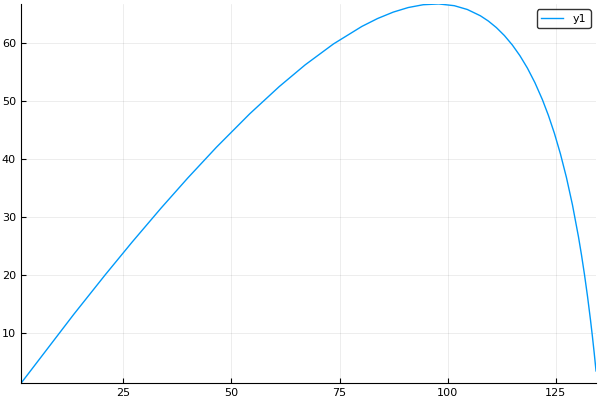

In [1]:
theta = 45
plot(x -> flight(x,  theta), 0, howfar(theta))

<p>To maximize the range we solve for the lone critical point of <code>howfar</code> within the range. The derivative can not be taken automatically with <code>D</code>. So,  here we use a central-difference approximation and start the search at 45 degrees, the angle which maximizes the trajectory on a non-windy day:</p>

In [1]:
h = 1e-5
howfarp(theta) = (howfar(theta+h) - howfar(theta-h)) / (2h)
tstar = find_zero(howfarp, 45)

26.262308915744917

<p>This graph shows the differences in the trajectories:</p>

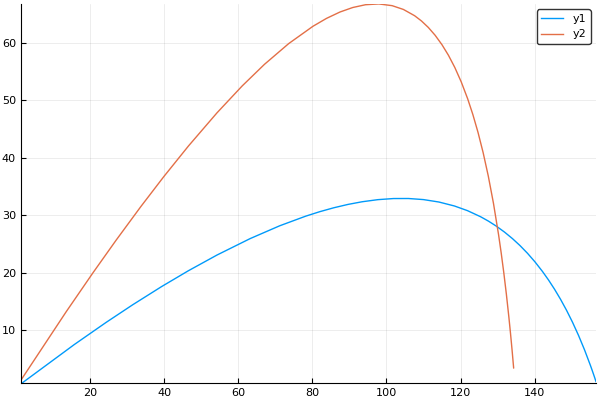

In [1]:
plot(x -> flight(x, tstar), 0, howfar(tstar))
plot!(x -> flight(x, 45), 0, howfar(45))

<h1>Use with other number types</h1>

<p>The <code>Unitful</code> package provides a means to attach units to numeric values.</p>

<p>For example, a projectile motion with $v_0=10$ and $x_0=16$ could be represented with:</p>

In [1]:
using Unitful
s = u"s"; m = u"m"
g = 9.8*m/s^2
v0 = 10m/s
y0 = 16m
y(t) = -g*t^2 + v0*t + y0

y (generic function with 1 method)

<p>This motion starts at a height of 16 meters and has an initial velocity of 10 meters per second.</p>

<p>The time of touching the ground is found with:</p>

In [1]:
a = find_zero(y, 1s, Order2())
a

1.8860533706680143 s

<p>Automatic derivatives don't propogate through <code>Unitful</code>, so we define the approximate derivative–paying attention to units–with:</p>

In [1]:
Df(f, h=1e-6) = x -> (f(x + h*oneunit(x)) - f(x)) / (h*oneunit(x))

Df (generic function with 2 methods)

<p>And then the fact the peak is the only local maximum, it can be found from:</p>

In [1]:
find_zero(Df(y), a/2, Order2())

0.5102035817463758 s

<hr />

<p>The <code>SymEngine</code> package provides symbolic values to <code>Julia</code>. Rather than passing a function to <code>find_zero</code>, we can pass a symbolic expression:</p>

In [1]:
using SymEngine
g, v0, y0 = 9.8, 10, 16
@vars t
yt = -g * t^2 + v0 * t + y0

16 + 10*t - 9.8*t^2

In [1]:
a = find_zero(yt, 1, Order2())
a

1.8860533706680143

<p>And the peak is determined to be at:</p>

In [1]:
find_zero(diff(yt, t), (0, a), Bisection())

0.510204081632653

<p>(This also illustrates that symbolic values can be passed to describe the <code>x</code>-axis values.)</p>

<p>Similarly, the <code>SymPy</code> package could be used in an identical way.</p>